In [11]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio

import time

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
# Hyperparameters
HEIGHT = 368
WIDTH  = 368

## Pre processing

In the pre-processing stage we only apply two transformations:

- Reduce size of image to HEIGHT, WIDTH
- Transform the image to pytorch tensor

We then store the tensors in new folders:'train_images_xx' and 'train_masks_xx' (you need to create those folders beforehand). The rest of transformations happen in the DataLoader. The reason is that size is constant for all images, therefore, we can apply to all images without exceptions. Similarly we can transfer all images to tensors because we do it for **all** images. Other transformations are applied randomly each time DataLoader outputs a batch (so same batch in 2 different epochs can have different transformations), therefore, we cannot include them in pre-process stage.

In [13]:
# Specify paths to your files (glob glob stores paths to all files in a folder in a list)
root = os.getcwd()
train_img_link_list  = sorted(glob.glob(root + '/data/train_images/*'))
train_mask_link_list = sorted(glob.glob(root + '/data/train_masks/*'))
test_img_link_list   = sorted(glob.glob(root + '/data/test_images/*'))

In [14]:
# Manual validation set list (handpicked examples):
val_img_list = [6414,6420,6433,6444,6468,6556,6565,6640,6715,7691,8368,8447,8817,8902,7233,
                6706,7256,7315,7321,7336,7525,7575,8917,8955,9107,6820,6843,6905,6966,6969]
val_img_list = [str(x) for x in val_img_list]

# Transformation pipeline
transform_img = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH]),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH], interpolation=Image.NEAREST),
    transforms.ToTensor()
])

transform_mask_prova = transforms.Compose([
    transforms.ToTensor()
])

# Iterate through all masks and images in train set, transform them and store corresponging tensors in a new folder
for i in tqdm(range(len(train_img_link_list))):
    
    img_id  = train_img_link_list[i].split('/')[-1].split('.')[0]
    mask_id = train_mask_link_list[i].split('/')[-1].split('.')[0]
    assert img_id == mask_id    # Make sure id's match
    
    img   = Image.open(train_img_link_list[i])
    mask  = Image.open(train_mask_link_list[i])

    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()
    
    if img_id in val_img_list:
        torch.save(img, f'data/val_images_{HEIGHT}/{img_id}.pt')
        torch.save(mask, f'data/val_masks_{HEIGHT}/{mask_id}.pt')
    else:
        torch.save(img, f'data/train_images_{HEIGHT}/{img_id}.pt')
        torch.save(mask, f'data/train_masks_{HEIGHT}/{mask_id}.pt')
    
print('Train and Validation sets created')

# Iterate through all images in test set, transform them and store corresponging tensors in a new folder
for i in tqdm(range(len(test_img_link_list))):
    
    img_id  = test_img_link_list[i].split('/')[-1].split('.')[0]
    
    img   = Image.open(test_img_link_list[i])
    img   = transform_img(img)
    torch.save(img, f'data/test_images_{HEIGHT}/{img_id}.pt')
    
    
print('Test set created')
    
#add images of minority classes
min_classses = [15, 17, 19, 20, 24]
count = 0

for i in tqdm(range(len(train_img_link_list))):
    
    img_id  = train_img_link_list[i].split('/')[-1].split('.')[0]
    mask_id = train_mask_link_list[i].split('/')[-1].split('.')[0]
    assert img_id == mask_id    # Make sure id's match
    
    img   = Image.open(train_img_link_list[i])
    mask  = Image.open(train_mask_link_list[i])

    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()

    if len(set(min_classses).intersection(set(mask.unique().tolist()))) > 0:

        cropped_img = T.FiveCrop(size=(HEIGHT//2,WIDTH//2))(img)
        cropped_mask = T.FiveCrop(size=(HEIGHT//2,WIDTH//2))(mask)
        
        for y in range(5):
            list_mask = [o_items for sublist in cropped_mask[y].tolist() for o_items in sublist]
            if any(items in min_classses for items in [o_items for sublist in list_mask for o_items in sublist]):
                
                mask_in_progress = transform_mask_prova(np.array([cropped_mask[y][0].tolist()]))
                
                torch.save(TF.resize(cropped_img[y], size=(HEIGHT, WIDTH)), f'data/train_images_{HEIGHT}/PLUS_{img_id}_{y}.pt')
                torch.save(TF.resize(mask_in_progress.permute(1,2,0), size=(HEIGHT, WIDTH)), f'data/train_masks_{HEIGHT}/PLUS_{img_id}_{y}.pt')
                count += 1
                
print('Additional', count, ' samples created')

  1%|          | 1/112 [00:00<00:19,  5.75it/s]

Train and Validation sets created


  0%|          | 0/261 [00:00<?, ?it/s]

Test set created


100%|██████████| 261/261 [00:58<00:00,  4.45it/s]

Additional 31  samples created


## Overview of additional samples

In [15]:
img_tensors_links  = sorted(glob.glob(root + f'/data/train_images_{HEIGHT}/*'))
mask_tensors_links = sorted(glob.glob(root + f'/data/train_masks_{HEIGHT}/*'))
img_tensors_links  = img_tensors_links[-31:]
mask_tensors_links = mask_tensors_links[-31:]

In [16]:
def show_random_images(i, img_links, mask_links):
    
    img = torch.load(img_links[i])
    mask = torch.load(mask_links[i])
    
    f, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    axarr[1].imshow(mask.permute(1,2,0).detach().numpy())
    plt.show()

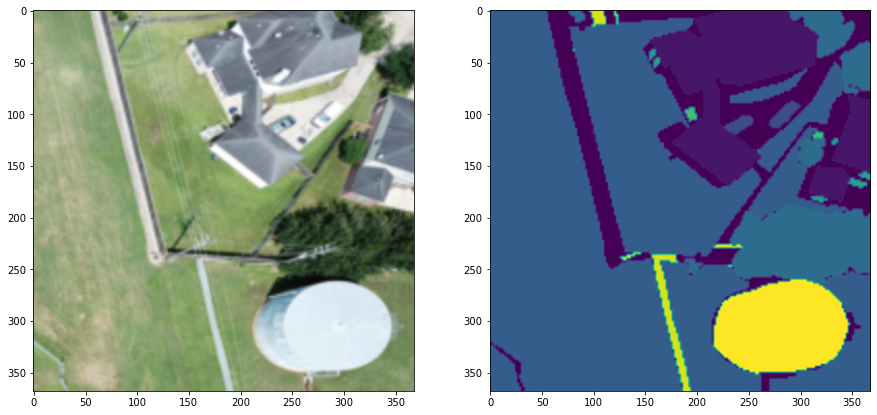

In [17]:
show_random_images(28, img_tensors_links, mask_tensors_links)

In [18]:
# Delete images that capture just a small fraction of the desired object
to_del = [5,11,12,13]
for item in to_del:
    os.remove(img_tensors_links[item])
    os.remove(mask_tensors_links[item])